<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/hr-analytics/hr-analytics/HR_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solving [HR Analytics Job Change](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists) using Neural Network and Google Colab

In [1]:
#hide
!pip install -Uqq fastbook kaggle
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.2 MB/s 
     |████████████████████████████████| 1.2 MB 37.6 MB/s 
     |████████████████████████████████| 46 kB 4.2 MB/s 
     |████████████████████████████████| 186 kB 46.2 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 51 kB 345 kB/s 
Mounted at /content/gdrive


Insert kaggle.json before proceed to the next step

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor

In [4]:
!rm -r ~/hr-analytics
!mkdir ~/hr-analytics

rm: cannot remove '/root/hr-analytics': No such file or directory


In [5]:
#Download dataset
api.dataset_download_cli(dataset='arashnic/hr-analytics-job-change-of-data-scientists',
                         path='hr-analytics',
                         unzip=True,
                         force=True)

100%|██████████| 295k/295k [00:00<00:00, 34.5MB/s]

In [6]:
train_ds = pd.read_csv('hr-analytics/aug_train.csv', low_memory=False)
test_ds = pd.read_csv('hr-analytics/aug_test.csv')

In [7]:
train_ds.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [8]:
dep_var = 'target'

## Baseline

In [17]:
train_ds['target'].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

What is the probability if I return false in every training data ? This data will be used as baseline

In [18]:
14381 / (14381 +  4777)

0.7506524689424784

This means 75% of accuracy

## Using Neural Network

In [19]:
cont,cat = cont_cat_split(train_ds, max_card=2000, dep_var=dep_var)
cont, cat

(['enrollee_id', 'city_development_index'],
 ['city',
  'gender',
  'relevent_experience',
  'enrolled_university',
  'education_level',
  'major_discipline',
  'experience',
  'company_size',
  'company_type',
  'last_new_job',
  'training_hours'])

In [20]:
procs = [Categorify, FillMissing, Normalize]
tabular_data = TabularPandas(train_ds, 
                      procs, 
                      cat, 
                      cont,
                      splits=RandomSplitter(valid_pct=0.2)(range_of(train_ds)), 
                      y_names=dep_var,
                      y_block = CategoryBlock )

In [21]:
dls = tabular_data.dataloaders(512)
dls.show_batch()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,enrollee_id,city_development_index,target
0,city_67,Male,Has relevent experience,no_enrollment,#na#,#na#,>20,5000-9999,Public Sector,>4,17,10930.000178,0.855,0.0
1,city_136,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,50-99,#na#,1,9,26745.000566,0.897,0.0
2,city_16,#na#,Has relevent experience,no_enrollment,Graduate,STEM,>20,10/49,Pvt Ltd,>4,282,7099.000463,0.910,0.0
3,city_21,Male,Has relevent experience,Full time course,Masters,STEM,1,50-99,Pvt Ltd,1,22,18506.000031,0.624,0.0
4,city_21,Male,Has relevent experience,no_enrollment,Graduate,STEM,6,<10,Funded Startup,1,88,21691.999776,0.624,0.0
5,city_103,#na#,No relevent experience,Full time course,Graduate,STEM,7,#na#,#na#,#na#,47,20226.000143,0.920,0.0
6,city_21,Male,No relevent experience,Full time course,Graduate,STEM,<1,#na#,#na#,never,64,33287.000082,0.624,1.0
7,city_136,#na#,Has relevent experience,no_enrollment,Masters,STEM,4,5000-9999,Public Sector,1,130,15748.999965,0.897,0.0
8,city_16,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,50-99,Pvt Ltd,1,70,19219.000013,0.910,0.0
9,city_70,Male,No relevent experience,no_enrollment,Graduate,STEM,6,#na#,#na#,never,23,8542.999991,0.698,1.0


In [27]:
learn = tabular_learner(dls,
                        metrics=[accuracy, RocAucBinary()])

SuggestedLRs(valley=0.001737800776027143)

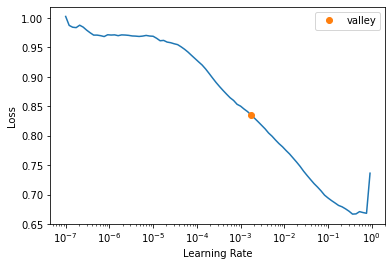

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(2, 3e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.523871,0.457881,0.787523,0.779486,00:00
1,0.466281,0.446767,0.788306,0.779973,00:00


SuggestedLRs(valley=0.001737800776027143)

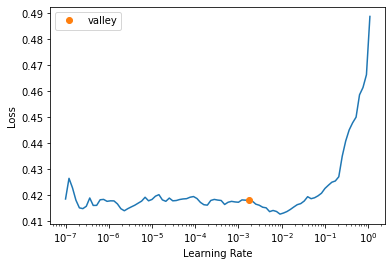

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(8, 1e-4, wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.417353,0.447832,0.787523,0.779894,00:00
1,0.416638,0.447459,0.786740,0.779786,00:00
2,0.415617,0.447735,0.786740,0.779745,00:00
3,0.415041,0.447492,0.787523,0.780037,00:00
4,0.413827,0.447463,0.786479,0.779969,00:00
5,0.413375,0.447693,0.788567,0.780307,00:00
6,0.413131,0.447865,0.788045,0.780136,00:00
7,0.412678,0.447814,0.786479,0.780115,00:00


## Possible Improvement

In [33]:
from sklearn.metrics import roc_auc_score
def r_roc_auc(y, pred): roc_auc_score(y, pred)
def m_roc_auc(m, y, xs): r_roc_auc(y, m.predict(xs))

## Prediction

In [ ]:
test_dl = learn.dls.test_dl(test_ds)
predictions = learn.get_preds(dl=test_dl)

In [ ]:
predictions, predictions[0][:,1]

((tensor([[0.9026, 0.0974],
          [0.7162, 0.2838],
          [0.4036, 0.5964],
          ...,
          [0.9044, 0.0956],
          [0.8896, 0.1104],
          [0.8680, 0.1320]]), None),
 tensor([0.0974, 0.2838, 0.5964,  ..., 0.0956, 0.1104, 0.1320]))

In [ ]:
result = pd.DataFrame({'enrollee_id': test_ds['enrollee_id'], 'target': predictions[0][:,1]})
result.to_csv('result.csv')